<a href="https://colab.research.google.com/github/guide2157/ThaiLicensePlateRecognizer/blob/master/CNNPlate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import cv2
import os
import pandas as pd
import tqdm

In [0]:
meta = pd.read_csv("LicenseChar.csv")

In [5]:
meta.head()

,id,char
0,0,ฎ
1,1,ต
2,2,8
3,3,ข
4,4,ต


In [0]:
import os

_, _, files = next(os.walk('/content/drive/My Drive/CharsImg'))
file_count = len(files)

In [0]:
images = np.zeros((file_count, 45, 50, 3))

In [8]:
counter = 0
for idx in tqdm.tqdm(meta['id']):
  path = '/content/drive/My Drive/CharsImg/{}.jpg'.format(idx)
  img = cv2.imread(path)
  img = cv2.resize(img,(50,45))
  img = img/255.
  images[counter] = img
  counter+=1

100%|██████████| 1039/1039 [13:01<00:00,  1.33it/s]


In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(meta['char'])

In [10]:
le.classes_

array([' ข', ' ศ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ก',
       'ข', 'ค', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ฌ', 'ญ', 'ฎ', 'ฐ', 'ฒ', 'ณ',
       'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 'พ', 'ภ', 'ม', 'ย',
       'ร', 'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ'], dtype=object)

In [0]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y = enc.fit_transform(np.reshape(labels, (-1,1)))

In [46]:
y.shape

(1039, 49)

Create model

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [0]:
inputs = Input(shape=(45,50, 3, ))

head = Conv2D(16, (3,3))(inputs)
head = BatchNormalization()(head)
head = Activation('relu')(head)
head = MaxPooling2D((2,2))(head)
head = Dropout(0.4)(head)
head = Conv2D(32, (3,3))(head)
head = BatchNormalization()(head)
head = Activation('relu')(head)
head = MaxPooling2D((2,2))(head)
head = Dropout(0.4)(head)
head = Flatten()(head)
head = Dense(128,'relu')(head)
outputs = Dense(len(le.classes_), 'softmax')(head)

model = Model(inputs, outputs)

In [0]:
optimizer = Adam()

model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, y.todense(), test_size=0.1, random_state=42)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
             EarlyStopping(monitor='val_loss', patience=4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

In [0]:
EPOCH=200
BS=16

In [88]:
history = model.fit(
    X_train,
    y_train,
    batch_size=BS,
    epochs=EPOCH,
    callbacks=callbacks,
    validation_data=(X_val, y_val)
)

Epoch 1/200
59/59 [==============================] - 1s 10ms/step - loss: 2.4350 - accuracy: 0.4834 - val_loss: 3.2309 - val_accuracy: 0.5769 - lr: 0.0010
Epoch 2/200
59/59 [==============================] - 0s 7ms/step - loss: 1.1384 - accuracy: 0.7476 - val_loss: 2.8476 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 3/200
59/59 [==============================] - 0s 7ms/step - loss: 0.8030 - accuracy: 0.8193 - val_loss: 2.3975 - val_accuracy: 0.5865 - lr: 0.0010
Epoch 4/200
59/59 [==============================] - 0s 7ms/step - loss: 0.5748 - accuracy: 0.8759 - val_loss: 1.7173 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 5/200
59/59 [==============================] - 0s 7ms/step - loss: 0.4431 - accuracy: 0.9005 - val_loss: 1.3854 - val_accuracy: 0.7596 - lr: 0.0010
Epoch 6/200
59/59 [==============================] - 0s 8ms/step - loss: 0.3382 - accuracy: 0.9080 - val_loss: 0.9138 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 7/200
59/59 [==============================] - 0s 7ms/step - loss: 0.

In [0]:
import matplotlib.pyplot as plt

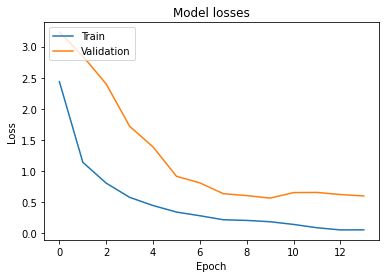

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Save model

In [0]:
import pickle

mapping = dict(zip(le.classes_, range(len(le.classes_))))
with open('result_mapping.pickle', 'wb') as handle:
    pickle.dump(mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
model.save("CNNLicense.h5")